## <span style="color:#0b486b">Set random seeds</span>

In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Download and preprocess the data</span>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later steps of a deep learning project. 

In [2]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            self.str_questions= list(); self.str_labels= list()
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [3]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['dist how far is it from denver to aspen ?', 'city what county is modesto , california in ?', 'desc who was galileo ?', 'def what is an atom ?', 'date when did hawaii become a state ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [4]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

train_str_questions contains the questions (inputs) of the training data set in string form, later to be converted to vector form. It is the x variable.

train_str_labels contains the classification for each corresponding sentence, there are 6 categories possible. It is the y variable.

In [5]:
print(dm.train_str_questions[0:5])
print(dm.train_numeral_labels[0:5])

['dist how far is it from denver to aspen ?', 'city what county is modesto , california in ?', 'desc who was galileo ?', 'def what is an atom ?', 'date when did hawaii become a state ?']
[5 4 3 1 5]


train_numeral_data  is a word2index representation for each question in the training set, where there is no embedding information but each value refers to the index in which the word is stored in the vocabulary/dictionary.


In [6]:
print(dm.train_numeral_data[0:5])

[[ 27  14  73   3 115  39 305  20 306   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 18   1 153   3 307 308   6   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 42  12   8 309   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 

word2idx is a dictionary that contains a key + value pair where word is the key to find what index (value) that particular word is in the vocabulary.

idx2word is a similar dictionary except the key is the index and word is the value returned, ie we input an index and get returned a word that corresponds to what word is in the vocabulary at that particular index

In [7]:
count = 0
for key,value in dm.word2idx.items():
    print(key,':',value)
    count += 1
    if count == 5:
        break

what : 1
the : 2
is : 3
def : 4
of : 5


In [8]:
count = 0
for key,value in dm.idx2word.items():
    print(key,':',value)
    count += 1
    if count == 5:
        break

1 : what
2 : the
3 : is
4 : def
5 : of


Store the X values (train_numeral_data) and label values (train_numeral_labels) training set in a combined Tensor object


In [9]:
count = 0
for X,y in dm.tf_train_set:
    print('X value is:',X)
    print('y value is:',y)
    count += 1
    if count == 5:
        break


X value is: tf.Tensor(
[ 27  14  73   3 115  39 305  20 306   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32)
y value is: tf.Tensor(5, shape=(), dtype=int32)
X value is: tf.Tensor(
[ 18   1 153   3 307 308   6   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32)
y value is: tf.Tensor(4, shape=(), d

Store the X values (valid_numeral_data) and label values (valid_numeral_labels) validation set in a combined Tensor object



In [10]:
#Your code here
count = 0
for X,y in dm.tf_valid_set:
    print(X)
    print(y)
    count += 1
    if count == 5:
        break

tf.Tensor(
[ 32   1   3   2 921 922 923 924   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(
[ 11  17   3 925  15  69   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(
[ 52   1  22   2 926 301 

## <span style="color:#0b486b">Using Word2Vect to transform texts to vectors </span>


In [11]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [12]:
word2vect = api.load("glove-wiki-gigaword-100")

In [13]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except KeyError: #word not in the vocabulary
        vector = np.zeros(100) #[model.size]
    return vector


- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if *important_score=None* is set by default, the function should return the average of all representation vectors corresponding to set *important_score=[1,1,...,1]*.**



In [14]:
def get_sentence_vector(sentence, important_score=None, model= None):
    sentence = sentence.split()
    L = len(sentence)

    if important_score is None:
        important_weight = np.ones(L)
    else:
        important_weight = tf.nn.softmax(important_score)
    
    final_vector = []
    
    for i in range(L):
        word = sentence[i]
        final_vector.append(important_weight[i] * get_word_vector(word,model))
        
    final_vector = sum(final_vector)
    final_vector = np.array(final_vector)
    return final_vector

In [15]:
print("Transform training set to feature vectors...")
important_score = [1,0.9,0.9,0.9,0.9,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.6,0.6,0.6] 
X_train= np.array([get_sentence_vector(sentence, important_score=important_score, model = word2vect) for sentence in dm.train_str_questions])
y_train= np.array([x for x in dm.train_numeral_labels]) #is it x+1?

Transform training set to feature vectors...


In [16]:
print("Transform valid set to feature vectors...")
important_score = [1,0.9,0.9,0.9,0.9,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.6,0.6,0.6] #can make it longer but max sentence length is 18
X_valid= np.array([get_sentence_vector(sentence, important_score=important_score, model = word2vect) for sentence in dm.valid_str_questions])
y_valid= np.array([x  for x in dm.valid_numeral_labels]) #is it x+1

Transform valid set to feature vectors...


In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

In [18]:
svm = SVC(kernel = 'rbf', C = 1,gamma = 2**-3)
#Insert your code for fitting svm on X_train
svm.fit(X_train,y_train)

SVC(C=1, gamma=0.125)

In [19]:
y_valid_pred= svm.predict(X_valid)
acc = accuracy_score(y_valid,y_valid_pred)
print(acc)

0.8585858585858586


## <span style="color:#0b486b">Text CNN for sequence modeling and neural embedding </span>


**Here is the description of the Text CNN**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times vocab\_size \times embed\_size]$ as $h$.
  - We feed $h$ to three Convd 1D layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()*  over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  

In [20]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size)(x)
        h1 = tf.keras.layers.Conv1D(filters = self.state_size,padding = 'same', activation = 'relu', kernel_size = 3)(h)
        h2 = tf.keras.layers.Conv1D(filters = self.state_size,padding = 'same', activation = 'relu', kernel_size = 5)(h)
        h3 = tf.keras.layers.Conv1D(filters = self.state_size,padding = 'same', activation = 'relu', kernel_size = 7)(h)
        h1 = tf.keras.layers.GlobalMaxPooling1D()(h1)
        h2 = tf.keras.layers.GlobalMaxPooling1D()(h2)
        h3 = tf.keras.layers.GlobalMaxPooling1D()(h3)
        h = tf.concat([h1,h2,h3],1)
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


In [21]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()
text_cnn.compile_model(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
text_cnn.model.fit(dm.train_numeral_data,dm.train_numeral_labels, epochs=20, validation_data= (dm.valid_numeral_data, dm.valid_numeral_labels))

Epoch 1/20
13/13 [==============================] - 1s 51ms/step - loss: 1.7046 - accuracy: 0.4115 - val_loss: 1.6551 - val_accuracy: 0.3939
Epoch 2/20
13/13 [==============================] - 0s 25ms/step - loss: 1.4767 - accuracy: 0.5411 - val_loss: 1.4885 - val_accuracy: 0.4040
Epoch 3/20
13/13 [==============================] - 0s 25ms/step - loss: 1.2419 - accuracy: 0.6334 - val_loss: 1.2750 - val_accuracy: 0.4848
Epoch 4/20
13/13 [==============================] - 0s 25ms/step - loss: 0.9920 - accuracy: 0.7382 - val_loss: 1.0353 - val_accuracy: 0.5859
Epoch 5/20
13/13 [==============================] - 0s 25ms/step - loss: 0.7447 - accuracy: 0.9227 - val_loss: 0.8023 - val_accuracy: 0.8485
Epoch 6/20
13/13 [==============================] - 0s 24ms/step - loss: 0.5414 - accuracy: 0.9626 - val_loss: 0.6537 - val_accuracy: 0.8687
Epoch 7/20
13/13 [==============================] - 0s 25ms/step - loss: 0.3871 - accuracy: 0.9751 - val_loss: 0.5438 - val_accuracy: 0.8788
Epoch 8/20
13

## <span style="color:#0b486b">RNNs for sequence modeling and neural embedding </span>

### <span style="color:#0b486b">One-directional RNNs </span> ###

In [22]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(units = state_size, return_sequences = return_sequences, activation = activation)
        elif cell_type== 'lstm':
            return tf.keras.layers.LSTM(units = state_size, return_sequences = return_sequences, activation = activation)
        else:
            return tf.keras.layers.SimpleRNN(units = state_size, return_sequences = return_sequences, activation = activation)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            return_seq_flag = True
            if i == (num_layers -1):
                return_seq_flag = False
            h =  self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= return_seq_flag, activation = 'tanh')(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


In [23]:
uni_rnn = UniRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 77ms/step - loss: 1.7925 - accuracy: 0.1920 - val_loss: 1.9401 - val_accuracy: 0.2626
Epoch 2/20
7/7 [==============================] - 0s 45ms/step - loss: 1.4924 - accuracy: 0.4314 - val_loss: 3.1253 - val_accuracy: 0.0101
Epoch 3/20
7/7 [==============================] - 0s 46ms/step - loss: 2.0189 - accuracy: 0.2444 - val_loss: 1.8717 - val_accuracy: 0.2525
Epoch 4/20
7/7 [==============================] - 0s 46ms/step - loss: 1.6532 - accuracy: 0.2718 - val_loss: 2.1038 - val_accuracy: 0.0000e+00
Epoch 5/20
7/7 [==============================] - 0s 43ms/step - loss: 1.5741 - accuracy: 0.3416 - val_loss: 1.6073 - val_accuracy: 0.3838
Epoch 6/20
7/7 [==============================] - 0s 43ms/step - loss: 1.6267 - accuracy: 0.3142 - val_loss: 2.4079 - val_accuracy: 0.0505
Epoch 7/20
7/7 [==============================] - 0s 41ms/step - loss: 1.5249 - accuracy: 0.3716 - val_loss: 1.8522 - val_accuracy: 0.2020
Epoch 8/20
7/7 [=======

In [24]:
uni_rnn = UniRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 196ms/step - loss: 1.7005 - accuracy: 0.2718 - val_loss: 1.8082 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 1s 105ms/step - loss: 1.6535 - accuracy: 0.2668 - val_loss: 1.7602 - val_accuracy: 0.2525
Epoch 3/20
7/7 [==============================] - 1s 102ms/step - loss: 1.6418 - accuracy: 0.2668 - val_loss: 1.7483 - val_accuracy: 0.2525
Epoch 4/20
7/7 [==============================] - 1s 102ms/step - loss: 1.6393 - accuracy: 0.2668 - val_loss: 1.7438 - val_accuracy: 0.2525
Epoch 5/20
7/7 [==============================] - 1s 104ms/step - loss: 1.6381 - accuracy: 0.2668 - val_loss: 1.7410 - val_accuracy: 0.2525
Epoch 6/20
7/7 [==============================] - 1s 101ms/step - loss: 1.6375 - accuracy: 0.2668 - val_loss: 1.7391 - val_accuracy: 0.2525
Epoch 7/20
7/7 [==============================] - 1s 107ms/step - loss: 1.6370 - accuracy: 0.2668 - val_loss: 1.7374 - val_accuracy: 0.2525
Epoch 8/20
7/7 [====

In [25]:
uni_rnn = UniRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 214ms/step - loss: 1.7242 - accuracy: 0.2668 - val_loss: 1.7451 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 1s 113ms/step - loss: 1.6469 - accuracy: 0.2843 - val_loss: 1.7722 - val_accuracy: 0.2525
Epoch 3/20
7/7 [==============================] - 1s 110ms/step - loss: 1.6437 - accuracy: 0.2668 - val_loss: 1.7591 - val_accuracy: 0.2525
Epoch 4/20
7/7 [==============================] - 1s 111ms/step - loss: 1.6407 - accuracy: 0.2668 - val_loss: 1.7517 - val_accuracy: 0.2525
Epoch 5/20
7/7 [==============================] - 1s 111ms/step - loss: 1.6393 - accuracy: 0.2668 - val_loss: 1.7467 - val_accuracy: 0.2525
Epoch 6/20
7/7 [==============================] - 1s 110ms/step - loss: 1.6385 - accuracy: 0.2668 - val_loss: 1.7429 - val_accuracy: 0.2525
Epoch 7/20
7/7 [==============================] - 1s 112ms/step - loss: 1.6378 - accuracy: 0.2668 - val_loss: 1.7394 - val_accuracy: 0.2525
Epoch 8/20
7/7 [====

### <span style="color:#0b486b">Bi-directional RNNs</span> ###



In [26]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = state_size, return_sequences = return_sequences, activation = activation))
        elif cell_type== 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = state_size, return_sequences = return_sequences, activation = activation))
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = state_size, return_sequences = return_sequences, activation = activation))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            
            return_seq_flag = True
            if i == (num_layers -1):
                return_seq_flag = False
            
            h =  self.get_layer(cell_type= self.cell_type, state_size= self.state_sizes[i], return_sequences= return_seq_flag, activation = 'tanh')(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)        


In [27]:
bi_rnn = BiRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 130ms/step - loss: 1.5615 - accuracy: 0.3616 - val_loss: 1.2216 - val_accuracy: 0.6566
Epoch 2/20
7/7 [==============================] - 0s 71ms/step - loss: 0.8727 - accuracy: 0.7506 - val_loss: 1.0899 - val_accuracy: 0.5051
Epoch 3/20
7/7 [==============================] - 1s 72ms/step - loss: 0.5128 - accuracy: 0.8554 - val_loss: 0.7265 - val_accuracy: 0.6566
Epoch 4/20
7/7 [==============================] - 0s 71ms/step - loss: 0.2281 - accuracy: 0.9576 - val_loss: 0.7089 - val_accuracy: 0.7374
Epoch 5/20
7/7 [==============================] - 0s 70ms/step - loss: 0.1033 - accuracy: 0.9776 - val_loss: 0.4697 - val_accuracy: 0.8485
Epoch 6/20
7/7 [==============================] - 0s 70ms/step - loss: 0.0492 - accuracy: 0.9950 - val_loss: 0.4161 - val_accuracy: 0.8990
Epoch 7/20
7/7 [==============================] - 0s 70ms/step - loss: 0.0273 - accuracy: 0.9975 - val_loss: 0.3493 - val_accuracy: 0.8990
Epoch 8/20
7/7 [==========

In [28]:
bi_rnn = BiRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 2s 334ms/step - loss: 1.6328 - accuracy: 0.2843 - val_loss: 2.0885 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 1s 172ms/step - loss: 1.4161 - accuracy: 0.4688 - val_loss: 1.2649 - val_accuracy: 0.4040
Epoch 3/20
7/7 [==============================] - 1s 169ms/step - loss: 1.0018 - accuracy: 0.6484 - val_loss: 1.0012 - val_accuracy: 0.4949
Epoch 4/20
7/7 [==============================] - 1s 171ms/step - loss: 0.6898 - accuracy: 0.8055 - val_loss: 0.8049 - val_accuracy: 0.6364
Epoch 5/20
7/7 [==============================] - 1s 181ms/step - loss: 0.4446 - accuracy: 0.8903 - val_loss: 0.7027 - val_accuracy: 0.7273
Epoch 6/20
7/7 [==============================] - 1s 169ms/step - loss: 0.3061 - accuracy: 0.9377 - val_loss: 0.6944 - val_accuracy: 0.7071
Epoch 7/20
7/7 [==============================] - 1s 170ms/step - loss: 0.2629 - accuracy: 0.9227 - val_loss: 0.6322 - val_accuracy: 0.7879
Epoch 8/20
7/7 [====

In [29]:
bi_rnn = BiRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64, 128], data_manager= dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 3s 389ms/step - loss: 1.7212 - accuracy: 0.2843 - val_loss: 1.9577 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 1s 199ms/step - loss: 1.6201 - accuracy: 0.3815 - val_loss: 1.6231 - val_accuracy: 0.3131
Epoch 3/20
7/7 [==============================] - 1s 203ms/step - loss: 1.3637 - accuracy: 0.4813 - val_loss: 1.2885 - val_accuracy: 0.4040
Epoch 4/20
7/7 [==============================] - 1s 200ms/step - loss: 1.0930 - accuracy: 0.5860 - val_loss: 1.3745 - val_accuracy: 0.4444
Epoch 5/20
7/7 [==============================] - 1s 196ms/step - loss: 0.8220 - accuracy: 0.7307 - val_loss: 0.9818 - val_accuracy: 0.6667
Epoch 6/20
7/7 [==============================] - 1s 201ms/step - loss: 0.6256 - accuracy: 0.7980 - val_loss: 0.7500 - val_accuracy: 0.7374
Epoch 7/20
7/7 [==============================] - 1s 198ms/step - loss: 0.4481 - accuracy: 0.8678 - val_loss: 0.7143 - val_accuracy: 0.7273
Epoch 8/20
7/7 [====

### <span style="color:#0b486b">RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###



**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.


In [30]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index, only has 100 embed size
            except KeyError: # word cannot be found
                vector = np.zeros(self.embed_size) 
        #np.save(self.embed_path, self.embed_matrix)
        #print(self.embed_matrix)
            
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        if network_type == 'uni-directional':
            if cell_type =='gru':
                return tf.keras.layers.GRU(units = hidden_size, return_sequences = return_sequences, activation = activation)
            elif cell_type == 'lstm':
                return tf.keras.layers.LSTM(units = hidden_size, return_sequences = return_sequences, activation = activation)
            else:
                return tf.keras.layers.SimpleRNN(units = hidden_size, return_sequences = return_sequences, activation = activation)
        
        if network_type == 'bi-directional':
            if cell_type =='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = hidden_size, return_sequences = return_sequences, activation = activation))
            elif cell_type == 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hidden_size, return_sequences = return_sequences, activation = activation))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = hidden_size, return_sequences = return_sequences, activation = activation))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        
        #Learns embedding matrix from scratch
        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        
        #Used pretrained embedding matrix
        else:
            self.build_embedding_matrix()
            if self.run_mode == 'init-fine-tune':
                h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True, weights=[self.embed_matrix])(x)
            else:
                h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False, weights=[self.embed_matrix])(x)
                
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            return_seq_flag = True
            if i == (num_layers -1):
                return_seq_flag = False
            h =  self.get_layer(cell_type= self.cell_type, hidden_size= self.state_sizes[i], return_sequences= return_seq_flag, activation = 'tanh')(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


In [31]:
RNN_mode_1 = RNN(network_type = 'uni-directional',run_mode = 'scratch',cell_type= 'lstm', embed_size= 64, state_sizes= [64, 128], data_manager= dm)
RNN_mode_1.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
RNN_mode_1.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
RNN_mode_1.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 202ms/step - loss: 1.7387 - accuracy: 0.2618 - val_loss: 1.8036 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 1s 104ms/step - loss: 1.6522 - accuracy: 0.2843 - val_loss: 1.7555 - val_accuracy: 0.2525
Epoch 3/20
7/7 [==============================] - 1s 104ms/step - loss: 1.6401 - accuracy: 0.2668 - val_loss: 1.7489 - val_accuracy: 0.2525
Epoch 4/20
7/7 [==============================] - 1s 105ms/step - loss: 1.6393 - accuracy: 0.2668 - val_loss: 1.7446 - val_accuracy: 0.2525
Epoch 5/20
7/7 [==============================] - 1s 105ms/step - loss: 1.6387 - accuracy: 0.2668 - val_loss: 1.7416 - val_accuracy: 0.2525
Epoch 6/20
7/7 [==============================] - 1s 104ms/step - loss: 1.6383 - accuracy: 0.2668 - val_loss: 1.7396 - val_accuracy: 0.2525
Epoch 7/20
7/7 [==============================] - 1s 104ms/step - loss: 1.6380 - accuracy: 0.2668 - val_loss: 1.7377 - val_accuracy: 0.2525
Epoch 8/20
7/7 [====

In [32]:
RNN_mode_2 = RNN(network_type = 'uni-directional',run_mode = 'init-only',cell_type= 'lstm', embed_size= 64, state_sizes= [64, 128], data_manager= dm)
RNN_mode_2.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
RNN_mode_2.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
RNN_mode_2.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 3s 435ms/step - loss: 1.5696 - accuracy: 0.4040 - val_loss: 1.3734 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 1s 122ms/step - loss: 0.9677 - accuracy: 0.6559 - val_loss: 0.8917 - val_accuracy: 0.5253
Epoch 3/20
7/7 [==============================] - 1s 122ms/step - loss: 0.6603 - accuracy: 0.7556 - val_loss: 0.6278 - val_accuracy: 0.7576
Epoch 4/20
7/7 [==============================] - 1s 122ms/step - loss: 0.4929 - accuracy: 0.8504 - val_loss: 0.7129 - val_accuracy: 0.6869
Epoch 5/20
7/7 [==============================] - 1s 122ms/step - loss: 0.3657 - accuracy: 0.8778 - val_loss: 0.5677 - val_accuracy: 0.7677
Epoch 6/20
7/7 [==============================] - 1s 122ms/step - loss: 0.3095 - accuracy: 0.8828 - val_loss: 0.5567 - val_accuracy: 0.7879
Epoch 7/20
7/7 [==============================] - 1s 123ms/step - loss: 0.2109 - accuracy: 0.9476 - val_loss: 0.3809 - val_accuracy: 0.8384
Epoch 8/20
7/7 [====

In [33]:
RNN_mode_3 = RNN(network_type = 'uni-directional',run_mode = 'init-fine-tune',cell_type= 'lstm', embed_size= 64, state_sizes= [64, 128], data_manager= dm)
RNN_mode_3.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
RNN_mode_3.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
RNN_mode_3.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 3s 445ms/step - loss: 1.5704 - accuracy: 0.4289 - val_loss: 1.3792 - val_accuracy: 0.4747
Epoch 2/20
7/7 [==============================] - 1s 128ms/step - loss: 0.9494 - accuracy: 0.6708 - val_loss: 0.8980 - val_accuracy: 0.5556
Epoch 3/20
7/7 [==============================] - 1s 130ms/step - loss: 0.6073 - accuracy: 0.7955 - val_loss: 0.6625 - val_accuracy: 0.6566
Epoch 4/20
7/7 [==============================] - 1s 126ms/step - loss: 0.4013 - accuracy: 0.8778 - val_loss: 0.5191 - val_accuracy: 0.7677
Epoch 5/20
7/7 [==============================] - 1s 132ms/step - loss: 0.2466 - accuracy: 0.9327 - val_loss: 0.4095 - val_accuracy: 0.8485
Epoch 6/20
7/7 [==============================] - 1s 132ms/step - loss: 0.2004 - accuracy: 0.9401 - val_loss: 0.2938 - val_accuracy: 0.8788
Epoch 7/20
7/7 [==============================] - 1s 126ms/step - loss: 0.1494 - accuracy: 0.9551 - val_loss: 0.5348 - val_accuracy: 0.7980
Epoch 8/20
7/7 [====


Mode 1 (run_mode ='scratch'): accuracy = 0.2525

Mode 2 (run_mode ='init-only'): accuracy = 0.8788

Mode 3 (run_mode ='init-fine-tune'): accuracy = 0.9495

Building our own embedding matrix from scratch isn't performing as well as suppose to first using a pre-trained model only. If we fine tune this pre-trained model further we achieve an even better model according to accuracy results of the three run modes.



Model 1 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: lstm, network_type: uni-directional ): accuracy = 0.92929

Model 2 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: lstm, network_type: bi-directional ): accuracy = 0.9090

Model 3 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: gru, network_type: uni-directional ): accuracy = 0.9191

Model 4 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: gru, network_type: bi-directional ): accuracy = 0.9191

Model 5 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: basic_rnn, network_type: uni-directional ): accuracy = 0.8989

Model 6 (run_mode:'init-fine-tune',state_size: [32, 64], cell_type: basic_rnn, network_type: bi-directional ): accuracy = 0.8383

Model 7 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: lstm, network_type: uni-directional ): accuracy = 0.9393

Model 8 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: lstm, network_type: bi-directional ): accuracy = 0.9494

Model 9 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: gru, network_type: uni-directional ): accuracy = 0.9696

Model 10 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: gru, network_type: bi-directional ): accuracy = 0.9292

Model 11 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: basic_rnn, network_type: uni-directional ): accuracy = 0.9393

Model 12 (run_mode:'init-fine-tune',state_size: [64, 128], cell_type: basic_rnn, network_type: bi-directional ): accuracy = 0.9191

Model 13 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: lstm, network_type: uni-directional ): accuracy = 0.9393

Model 14 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: lstm, network_type: bi-directional ): accuracy = 0.9191

Model 15 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: gru, network_type: uni-directional ): accuracy = 0.9090

Model 16 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: gru, network_type: bi-directional ): accuracy = 0.9393

Model 17 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: basic_rnn, network_type: uni-directional ): accuracy = 0.8383

Model 18 (run_mode:'init-fine-tune',state_size: [32,64,128], cell_type: basic_rnn, network_type: bi-directional ): accuracy = 0.9292



In [445]:
gs_state_sizes = [[32,64],[64,128],[32,64,128]]
cell_type = ['lstm','gru','simple']
network_type = ['uni-directional','bi-directional']
best_acc = 0
best_state_sizes = []
best_embed_sizes = []

tf.random.set_seed(6789)
np.random.seed(6789)

for i in range(len(gs_state_sizes)):
    for j in range(len(cell_type)):
        for k in range(len(network_type)):
        
        #Make temporary RNN
            print('state_size:',gs_state_sizes[i],'cell_type:',cell_type[j],'network_type:',network_type[k])

            RNN_grid_search = RNN(network_type = network_type[k],run_mode = 'init-fine-tune',cell_type= cell_type[j], embed_size= 128, state_sizes= gs_state_sizes[i], data_manager= dm)
            RNN_grid_search.build()
            opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
            RNN_grid_search.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            RNN_grid_search.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

            #Compute Accuracy
            preds = RNN_grid_search.model.predict(dm.valid_numeral_data)
            y_hat = np.argmax(preds,axis = 1)
            acc = accuracy_score(dm.valid_numeral_labels,y_hat)

            print(acc)
            if acc > best_acc:
                best_state_sizes = gs_state_sizes[i]
                best_cell_type = cell_type[j]
                best_network_type = network_type[k]
                best_acc = acc


state_size: [32, 64] cell_type: lstm network_type: uni-directional
Epoch 1/20
7/7 [==============================] - 45s 6s/step - loss: 1.6607 - accuracy: 0.4065 - val_loss: 1.5788 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 1s 183ms/step - loss: 1.3037 - accuracy: 0.6060 - val_loss: 1.2010 - val_accuracy: 0.5051
Epoch 3/20
7/7 [==============================] - 1s 190ms/step - loss: 0.9091 - accuracy: 0.7257 - val_loss: 0.9393 - val_accuracy: 0.5859
Epoch 4/20
7/7 [==============================] - 1s 182ms/step - loss: 0.6524 - accuracy: 0.8055 - val_loss: 0.8068 - val_accuracy: 0.6162
Epoch 5/20
7/7 [==============================] - 1s 178ms/step - loss: 0.4918 - accuracy: 0.8554 - val_loss: 0.7436 - val_accuracy: 0.6263
Epoch 6/20
7/7 [==============================] - 1s 177ms/step - loss: 0.3887 - accuracy: 0.8853 - val_loss: 0.6768 - val_accuracy: 0.6566
Epoch 7/20
7/7 [==============================] - 1s 177ms/step - loss: 0.3052 - accuracy: 0.90

In [464]:
print(best_acc)
print(best_state_sizes)
print(best_cell_type)
print(best_network_type)

0.9696969696969697
[64, 128]
gru
uni-directional


In [34]:
my_best_rnn = RNN(network_type = 'uni-directional',run_mode = 'init-fine-tune',cell_type= 'gru', embed_size= 256, state_sizes= [64, 128], data_manager= dm)
my_best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 3s 423ms/step - loss: 1.5016 - accuracy: 0.4264 - val_loss: 1.2896 - val_accuracy: 0.4040
Epoch 2/20
7/7 [==============================] - 1s 111ms/step - loss: 1.0412 - accuracy: 0.5736 - val_loss: 1.0705 - val_accuracy: 0.4343
Epoch 3/20
7/7 [==============================] - 1s 110ms/step - loss: 0.7985 - accuracy: 0.7182 - val_loss: 0.8490 - val_accuracy: 0.5657
Epoch 4/20
7/7 [==============================] - 1s 110ms/step - loss: 0.5773 - accuracy: 0.7905 - val_loss: 0.6447 - val_accuracy: 0.7374
Epoch 5/20
7/7 [==============================] - 1s 110ms/step - loss: 0.3980 - accuracy: 0.8778 - val_loss: 0.4502 - val_accuracy: 0.8384
Epoch 6/20
7/7 [==============================] - 1s 116ms/step - loss: 0.3339 - accuracy: 0.8853 - val_loss: 0.4262 - val_accuracy: 0.8283
Epoch 7/20
7/7 [==============================] - 1s 113ms/step - loss: 0.2181 - accuracy: 0.9252 - val_loss: 0.3505 - val_accuracy: 0.8485
Epoch 8/20
7/7 [====

### <span style="color:#0b486b">RNNs with Attention for Text and Sequence Classification</span> ###


**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.


#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [35]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyAttention, self).__init__()
        self.U = tf.keras.layers.Dense(output_length)
        self.V = tf.keras.layers.Dense(1)
    
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        attention_score = self.V(tf.keras.activations.tanh(self.U(all_states)))       
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        context = tf.reduce_sum(tf.linalg.matmul(tf.transpose(attention_weight, perm=[0,2,1]), all_states), axis=1)
        return context, attention_weight


In [36]:
class Attention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
        self.attention = MyAttention(200)
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index, only has 100 embed size
            except KeyError: # word cannot be found
                vector = np.zeros(self.embed_size) 
        #np.save(self.embed_path, self.embed_matrix)
        #print(self.embed_matrix)
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_state = False, return_sequences= False, activation = 'tanh'):
        if network_type == 'uni-directional':
            if cell_type =='gru':
                return tf.keras.layers.GRU(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation)
            elif cell_type == 'lstm':
                return tf.keras.layers.LSTM(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation)
            else:
                return tf.keras.layers.SimpleRNN(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation)
        
        if network_type == 'bi-directional':
            if cell_type =='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation))
            elif cell_type == 'lstm':
                return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation))
            else:
                return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = hidden_size, return_sequences = return_sequences, return_state = return_state, activation = activation))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        
        #Learns embedding matrix from scratch
        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        
        #Used pretrained embedding matrix
        else:
            self.build_embedding_matrix()
            if self.run_mode == 'init-fine-tune':
                h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True, weights=[self.embed_matrix])(x)
            else:
                h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False, weights=[self.embed_matrix])(x)
                
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            
            return_state_flag = False
            
            if i == (num_layers -1):
                return_state_flag = True
                
                if self.cell_type == 'lstm':
                    whole_sequence_output, final_memory_state, final_carry_state =  self.get_layer(cell_type= self.cell_type, hidden_size= self.state_sizes[i], return_state = return_state_flag, return_sequences= True, activation = 'tanh')(h)
                    context, attention_weight = self.attention(whole_sequence_output, final_memory_state)
                    h = tf.concat([final_memory_state, context], axis=1)
                    
                else:
                    whole_sequence_output, final_state =  self.get_layer(cell_type= self.cell_type, hidden_size= self.state_sizes[i], return_state = return_state_flag, return_sequences= True, activation = 'tanh')(h)
                
                    context, attention_weight = self.attention(whole_sequence_output, final_state)
                
                    h = tf.concat([final_state, context], axis=1)
                
                h = tf.keras.layers.Dense(200, activation="tanh")(h)
                
            else:
                h =  self.get_layer(cell_type= self.cell_type, hidden_size= self.state_sizes[i], return_state = return_state_flag, return_sequences= True, activation = 'tanh')(h)
            
        
        #print(whole_sequence_output.shape, final_state.shape)
        #print(h.shape)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       

In [37]:
#Standard RNN
standard_rnn = RNN(network_type = 'uni-directional',run_mode = 'scratch',cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128], data_manager= dm)
standard_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
standard_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
standard_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 72ms/step - loss: 1.8290 - accuracy: 0.2394 - val_loss: 1.9266 - val_accuracy: 0.2525
Epoch 2/20
7/7 [==============================] - 0s 39ms/step - loss: 1.6553 - accuracy: 0.2793 - val_loss: 1.8826 - val_accuracy: 0.2525
Epoch 3/20
7/7 [==============================] - 0s 38ms/step - loss: 1.6515 - accuracy: 0.2793 - val_loss: 1.8586 - val_accuracy: 0.2525
Epoch 4/20
7/7 [==============================] - 0s 42ms/step - loss: 1.7380 - accuracy: 0.2394 - val_loss: 1.8438 - val_accuracy: 0.2525
Epoch 5/20
7/7 [==============================] - 0s 42ms/step - loss: 1.6396 - accuracy: 0.2843 - val_loss: 1.7190 - val_accuracy: 0.3232
Epoch 6/20
7/7 [==============================] - 0s 43ms/step - loss: 1.6553 - accuracy: 0.2594 - val_loss: 1.8377 - val_accuracy: 0.2525
Epoch 7/20
7/7 [==============================] - 0s 38ms/step - loss: 1.7094 - accuracy: 0.2070 - val_loss: 1.8104 - val_accuracy: 0.2525
Epoch 8/20
7/7 [===========

In [38]:
#Attention RNN
attention_rnn = Attention_RNN(network_type = 'uni-directional',run_mode = 'scratch',cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128], data_manager= dm)
attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 1s 93ms/step - loss: 1.9585 - accuracy: 0.1372 - val_loss: 2.0404 - val_accuracy: 0.3333
Epoch 2/20
7/7 [==============================] - 0s 49ms/step - loss: 1.8162 - accuracy: 0.2693 - val_loss: 2.2669 - val_accuracy: 0.2525
Epoch 3/20
7/7 [==============================] - 0s 49ms/step - loss: 1.6866 - accuracy: 0.3416 - val_loss: 1.4298 - val_accuracy: 0.4848
Epoch 4/20
7/7 [==============================] - 0s 49ms/step - loss: 1.6070 - accuracy: 0.3441 - val_loss: 1.6106 - val_accuracy: 0.3636
Epoch 5/20
7/7 [==============================] - 0s 49ms/step - loss: 1.1629 - accuracy: 0.5337 - val_loss: 1.6428 - val_accuracy: 0.3535
Epoch 6/20
7/7 [==============================] - 0s 49ms/step - loss: 0.9974 - accuracy: 0.6209 - val_loss: 1.3529 - val_accuracy: 0.4848
Epoch 7/20
7/7 [==============================] - 0s 49ms/step - loss: 0.8839 - accuracy: 0.6010 - val_loss: 1.2669 - val_accuracy: 0.4949
Epoch 8/20
7/7 [===========

Standard RNN (network_type = 'uni-directional',run_mode = 'scratch',cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128]):  accuracy = 0.2828

Attention RNN (network_type = 'uni-directional',run_mode = 'scratch',cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64,128]): accuracy = 0.9394

We can clearly see that the attention mechanism drastically improves this very basic rnn model, recall that we use a basic RNN and make our own embedding matrix using an embedding layer, only a few states + layers and only one directional flow. Clealy settings for a simple RNN model, we can see it performs very poorly without attention but with attention the model performs outstanding reaching high accuracy of 0.9394, imagine in combination with a better embedding method, bi-directional, LSTM cell type and more layers+ states, we might create an even more outstanding method (hopefully avoiding overfitting).

### <span style="color:#0b486b">Investigating the embedding vectors from the embedding matrix</span> ###


In [39]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

In [40]:
def find_most_similar(word= None, k=5, model= None):
    try:
        #model.build_embedding_matrix()
        embed_matrix = model.embed_matrix
        vocab_size = len(embed_matrix)
        word_idx = model.word2idx[word]
        word_vector = embed_matrix[word_idx] #should be length of word.embed_size
        top_k_similar = []
        vocab_cos_sin = [0] * vocab_size
        
        for i in range(1,vocab_size):
            target_word_vector = embed_matrix[i]
            cos_sin = cosine_similarity(word_vector,target_word_vector)
            vocab_cos_sin[i] = cos_sin
        
        vocab_cos_sin = sorted(vocab_cos_sin,reverse = True)
        
        top_k_cos_sin = vocab_cos_sin[0:k]
        
        for j in range(len(top_k_cos_sin)):
            for i in range(1,vocab_size):
                target_word_vector = embed_matrix[i]
                cos_sin = cosine_similarity(word_vector,target_word_vector)
                if cos_sin == top_k_cos_sin[j]:
                    top_k_similar.append((top_k_cos_sin[j],dm.idx2word[i]))
                    break
        
        return top_k_similar
            
    except KeyError: #word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [41]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

<ipython-input-39-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


[(0.627512091962913, 'italy'),
 (0.6134157936125213, 'soviet'),
 (0.5910070570827871, 'turkey'),
 (0.5765769525153158, 'spain'),
 (0.560642026450888, 'yugoslavia'),
 (0.5559693741980682, 'luxembourg'),
 (0.5397791371211339, 'canada'),
 (0.516157704342097, 'german'),
 (0.4962832578796011, 'northern'),
 (0.48277339350762927, 'states')]

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)

def plot3D_with_labels(word= None, model= None, k= 10):
    top_k_similar = find_most_similar(word=word, k=k, model= model)
    k_words = [word]
    k_words_vecs = []
    embed_matrix = model.embed_matrix
    word_idx = model.word2idx[word]
    word_vector = embed_matrix[word_idx]
    k_words_vecs.append(word_vector)
    
    labels = [(word,1)]

    for i in range(len(top_k_similar)):
        k_words.append(top_k_similar[i][1])
        labels.append((top_k_similar[i][1],top_k_similar[i][0]))

    
    for i in range(len(k_words)):
        word_idx = model.word2idx[k_words[i]]
        word_vector = embed_matrix[word_idx]
        k_words_vecs.append(word_vector)
        

    
    low_dim_embs = tsne.fit_transform(k_words_vecs)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(labels):
        if i == 0:
            x1,y1,z1 = low_dim_embs[0,:]
            ax.scatter(x1, y1, z1, color = 'blue')
            ax.text(x1, y1, z1, word, color = 'red')
        else:
            x,y,z =  low_dim_embs[i,:]
            ax.scatter(x, y, z, color = 'blue')
            ax.text(x, y, z, label[0], color = 'green')
        
    
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()


<ipython-input-39-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


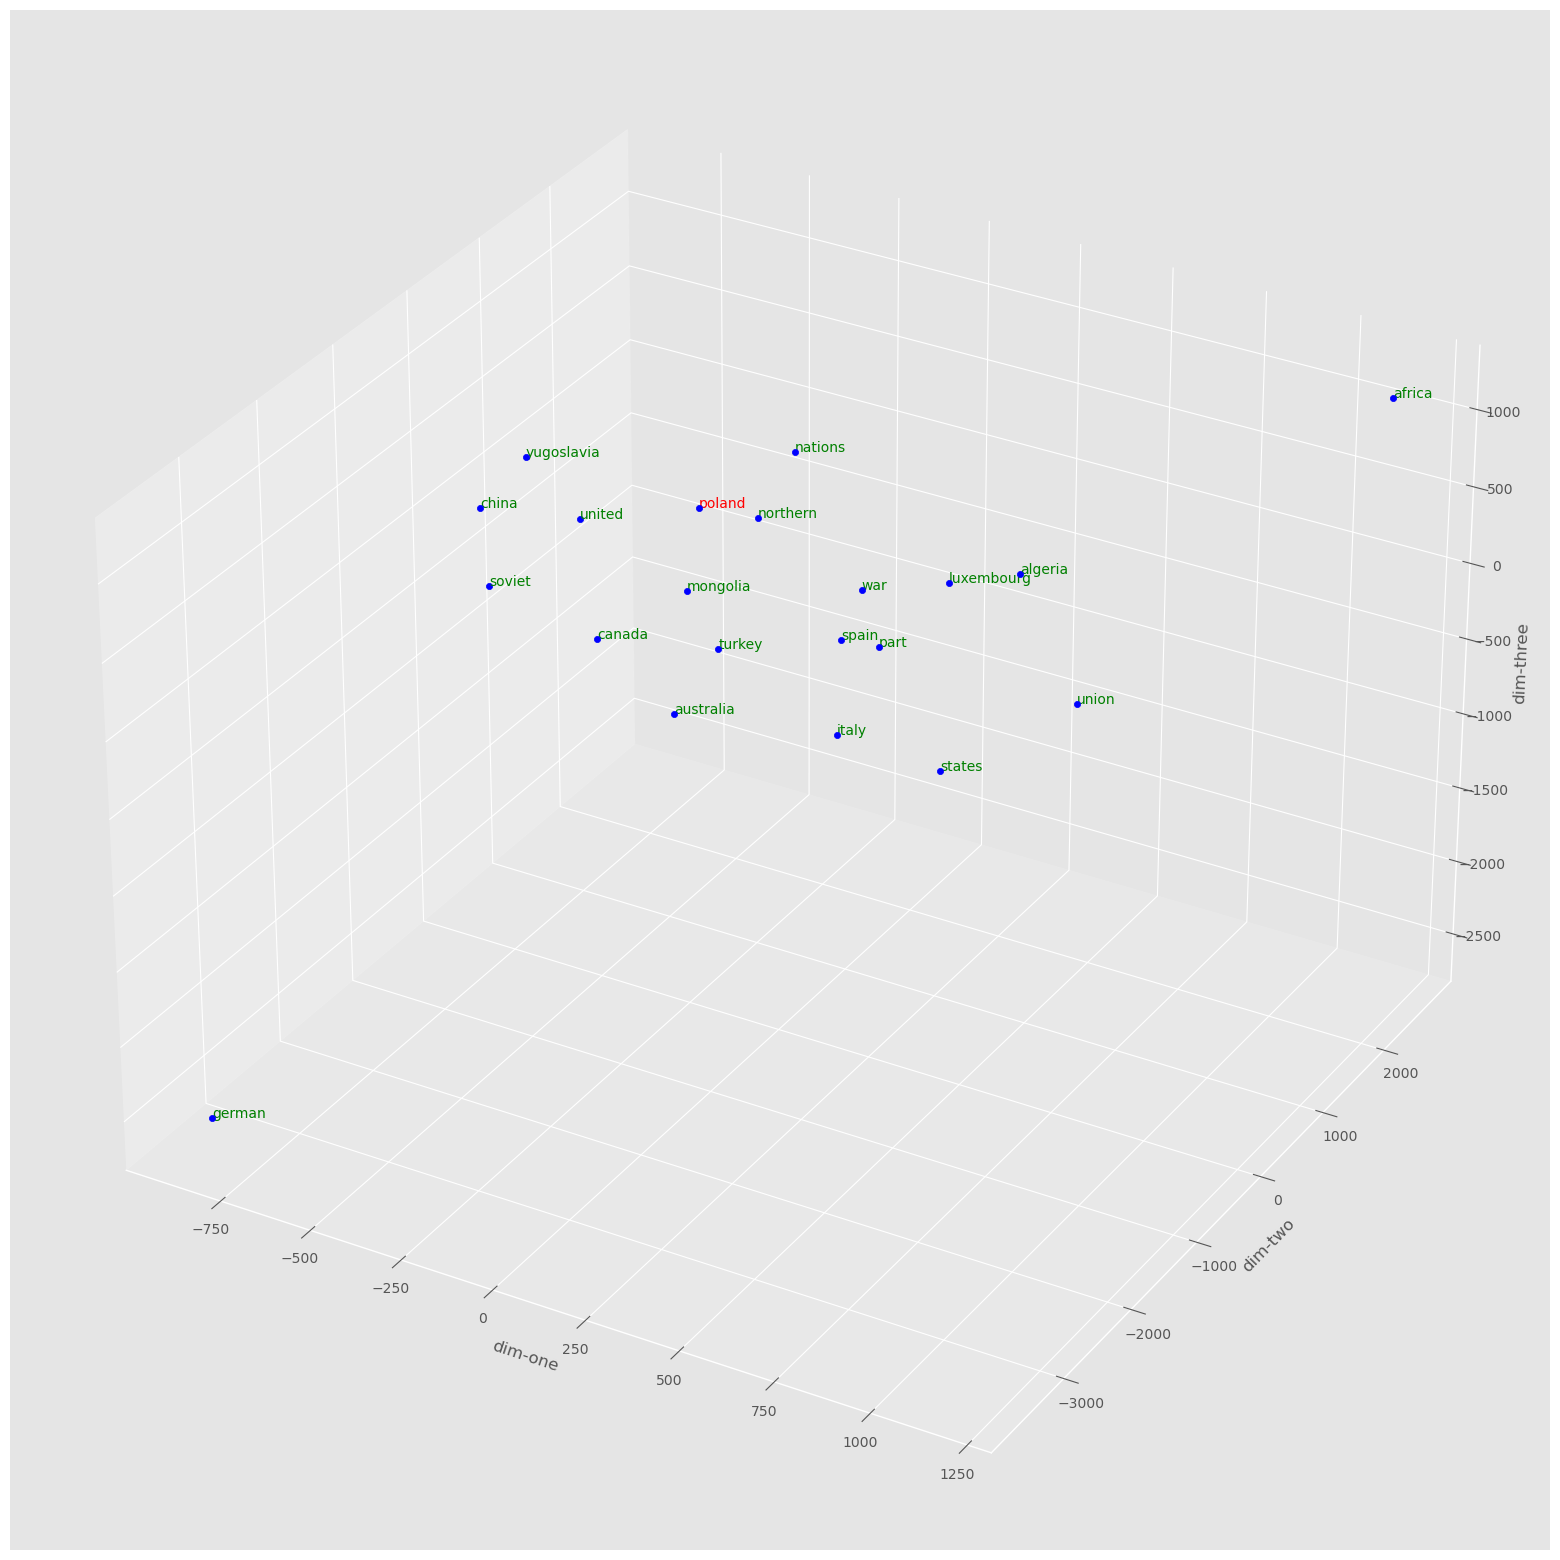

In [43]:
tf.random.set_seed(6789)
np.random.seed(6789)

plot3D_with_labels(word='poland', k=20, model= my_best_rnn)